In [1]:
# importing required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# reading train and test data
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
test_data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [5]:
test_data['Item_Fat_Content'].unique()

array(['Low Fat', 'reg', 'Regular', 'LF', 'low fat'], dtype=object)

In [6]:
# combining Item_Fat_Content misspelled
train_data['Item_Fat_Content'].replace(['low fat','LF','reg'],['Low Fat','Low Fat','Regular'],inplace = True)
test_data['Item_Fat_Content'].replace(['low fat','LF','reg'],['Low Fat','Low Fat','Regular'],inplace = True)

In [7]:
# creating new column num_years
train_data['num_years'] = train_data['Outlet_Establishment_Year'].apply(lambda x: 2013 - x) 
test_data['num_years'] = test_data['Outlet_Establishment_Year'].apply(lambda x: 2013 - x) 

In [8]:
train_data['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

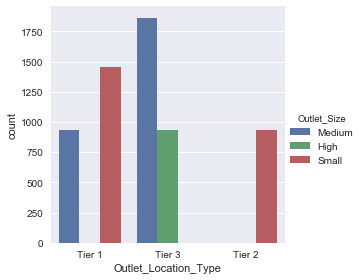

In [9]:
sns.factorplot('Outlet_Location_Type',data = train_data,hue ='Outlet_Size' ,kind='count')

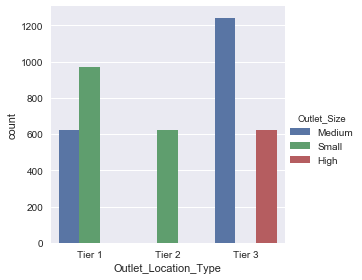

In [10]:
sns.factorplot('Outlet_Location_Type',data = test_data,hue ='Outlet_Size' ,kind='count')

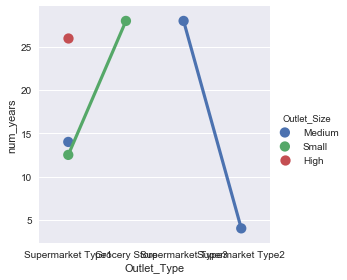

In [11]:
sns.factorplot('Outlet_Type','num_years',data = test_data,hue='Outlet_Size' )

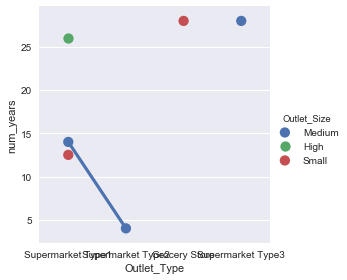

In [12]:
sns.factorplot('Outlet_Type','num_years',data = train_data,hue='Outlet_Size' )

In [13]:
full_data = [train_data, test_data]

In [14]:
# filling null values
for data in full_data:
    data['Item_Weight'].fillna(data['Item_Weight'].mean(),inplace = True)
    data['Outlet_Size'].fillna('Medium',inplace = True)    

In [15]:
col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

In [16]:
# handling catagorical variables
train_datar = pd.get_dummies(train_data, columns = col, drop_first = True)
test_datar = pd.get_dummies(test_data, columns = col,drop_first = True)

In [17]:
feat_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'num_years',
       'Item_Fat_Content_Regular', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3']

In [18]:
X = train_datar[feat_cols]
y = train_datar['Item_Outlet_Sales']

In [19]:
# splitting data as X_train and X_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 0)


In [20]:
# creating XGBoost model
from xgboost.sklearn import XGBRegressor
XGB = XGBRegressor()
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

In [21]:
# calculating RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))

In [22]:
rmse

1098.2495755279024

In [23]:
# predicting on actual test data
X_t = test_datar[feat_cols]
y_result = XGB.predict(X_t)

In [24]:
y_result

array([ 1589.19445801,  1411.19580078,  1019.76318359, ...,  1862.66821289,
        4009.51416016,  1298.359375  ], dtype=float32)

In [22]:
#creating results .csv file
result = pd.DataFrame()
result['Item_Identifier'] = test_datar['Item_Identifier']
result['Outlet_Identifier'] = test_datar['Outlet_Identifier']

result["Item_Outlet_Sales"] = y_result
result = result.sort_index()
result.to_csv('Bigmart_XGBoost3.csv',index = False)
